Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
import os

In [8]:
zipfile.ZipFile('./drive/MyDrive/bigdata/stock-data.zip').extractall()

In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [134]:
#read data
# kernels let us navigate through the zipfile as if it were a directory

# trying to read a file of size zero will throw an error, so skip them
# filenames = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(x) > 0]
# filenames = random.sample(filenames,1)
filenames = ['./Stocks/prk.us.txt', './Stocks/bgr.us.txt', './Stocks/jci.us.txt', './Stocks/aa.us.txt', './Stocks/fr.us.txt', './Stocks/star.us.txt', './Stocks/sons.us.txt', './Stocks/ipl_d.us.txt', './Stocks/sna.us.txt', './Stocks/utg.us.txt']
filenames = [filenames[1]]
print(filenames)

data = []
for filename in filenames:
    df = pd.read_csv(filename, sep=',')
    filename = filename.split(sep='/')[2]
    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    data.append(df)

['./Stocks/bgr.us.txt']


In [135]:
print(type(data[0]))

<class 'pandas.core.frame.DataFrame'>


In [136]:
r = lambda: random.randint(0,255)
traces = []

for df in data:
    clr = str(r()) + str(r()) + str(r())
#     df = df.sample(n=100, replace=True)
    df = df.sort_values('Date')
#     print(df['Label'])
    label = df['Label'].iloc[0]

    trace = plotly.graph_objs.Scattergl(
        x=df['Date'],
        y=df['Close'],
        mode='lines+text',
        line=dict(
            color = "rgb(255,0,0)"
        )
    )
    traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot',
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')

In [137]:
dd = data[0]
print(dd)

           Date    Open     High     Low   Close  Volume  OpenInt       Label
0    2005-02-25  12.130  12.2330  11.991  12.115  287699        0  bgr.us.txt
1    2005-02-28  12.147  12.2080  12.109  12.158  196150        0  bgr.us.txt
2    2005-03-01  12.158  12.1830  12.081  12.141  155314        0  bgr.us.txt
3    2005-03-02  12.176  12.2330  12.135  12.170  124179        0  bgr.us.txt
4    2005-03-03  12.141  12.2770  12.120  12.246  225421        0  bgr.us.txt
...         ...     ...      ...     ...     ...     ...      ...         ...
3196 2017-11-06  13.780  14.0200  13.780  14.020  173494        0  bgr.us.txt
3197 2017-11-07  14.050  14.0500  13.970  14.040  177874        0  bgr.us.txt
3198 2017-11-08  14.030  14.0800  13.880  14.060  228212        0  bgr.us.txt
3199 2017-11-09  14.000  14.1001  13.900  14.100  165542        0  bgr.us.txt
3200 2017-11-10  14.040  14.1500  13.950  14.080  177498        0  bgr.us.txt

[3201 rows x 8 columns]


In [138]:
dd = dd.drop(['Label'], axis=1)
print(dd)

           Date    Open     High     Low   Close  Volume  OpenInt
0    2005-02-25  12.130  12.2330  11.991  12.115  287699        0
1    2005-02-28  12.147  12.2080  12.109  12.158  196150        0
2    2005-03-01  12.158  12.1830  12.081  12.141  155314        0
3    2005-03-02  12.176  12.2330  12.135  12.170  124179        0
4    2005-03-03  12.141  12.2770  12.120  12.246  225421        0
...         ...     ...      ...     ...     ...     ...      ...
3196 2017-11-06  13.780  14.0200  13.780  14.020  173494        0
3197 2017-11-07  14.050  14.0500  13.970  14.040  177874        0
3198 2017-11-08  14.030  14.0800  13.880  14.060  228212        0
3199 2017-11-09  14.000  14.1001  13.900  14.100  165542        0
3200 2017-11-10  14.040  14.1500  13.950  14.080  177498        0

[3201 rows x 7 columns]


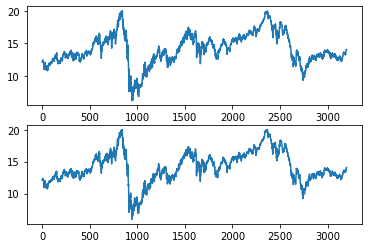

In [139]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(dd.Open)
ax[1].plot(dd.Close)

In [140]:
df = data[0]
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data[0]["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [141]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [142]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
3170/3170 - 15s - loss: 0.0191 - 15s/epoch - 5ms/step
Epoch 2/5
3170/3170 - 13s - loss: 0.0144 - 13s/epoch - 4ms/step
Epoch 3/5
3170/3170 - 13s - loss: 0.0137 - 13s/epoch - 4ms/step
Epoch 4/5
3170/3170 - 12s - loss: 0.0135 - 12s/epoch - 4ms/step
Epoch 5/5
3170/3170 - 12s - loss: 0.0133 - 12s/epoch - 4ms/step


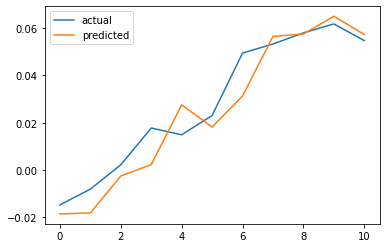

The Mean Absolute Error is: 0.007192662876553079


In [143]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

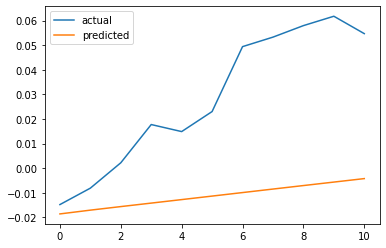

The Mean Absolute Error is: 0.03969416698626807


In [144]:
#https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

XGBoost

In [315]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with the 'colab' Renderer"
)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [316]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [317]:
ETF_NAME = 'CERN'
ETF_DIRECTORY = './Stocks/'

df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2011)].copy()
df.index = range(len(df))

df.head()

Date    Open    High     Low   Close   Volume  OpenInt
0 2011-01-03  23.818  24.398  23.818  23.975  2315772        0
1 2011-01-04  23.920  23.943  23.305  23.590  2558192        0
2 2011-01-05  23.423  23.653  23.015  23.613  2096424        0
3 2011-01-06  23.555  23.865  23.533  23.658  1099844        0
4 2011-01-07  23.713  23.730  23.490  23.720  1127024        0

In [318]:
cr_df = pd.read_csv(os.path.join("./", "coin_Ethereum" + '.csv'), sep=',')

drop_cr_col = ['SNo', "Name", "Symbol", "Marketcap"]

cr_df['Date'] = pd.to_datetime(df['Date'])
cr_df = cr_df[(cr_df['Date'].dt.year >= 2014)].copy()
cr_df.index = range(len(cr_df))

cr_df = cr_df.drop(drop_cr_col, 1)

cr_df.head()

Date        High         Low        Open       Close        Volume
0 2014-01-02  388.747986  361.971008  369.472992  378.484985  1.333320e+09
1 2014-01-03  386.139008  376.354004  378.441010  383.041992  7.062540e+08
2 2014-01-06  390.044006  383.467010  383.467010  387.740997  8.742220e+08
3 2014-01-07  389.352997  328.095001  387.824005  348.984009  1.483600e+09
4 2014-01-08  366.487000  332.231995  350.229004  347.484009  9.862660e+08

In [319]:
# configure_plotly_browser_state()

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show(renderer="colab")

In [320]:
# configure_plotly_browser_state()

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=cr_df.Date,
                      open=cr_df.Open,
                      high=cr_df.High,
                      low=cr_df.Low,
                      close=cr_df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show(renderer="colab")

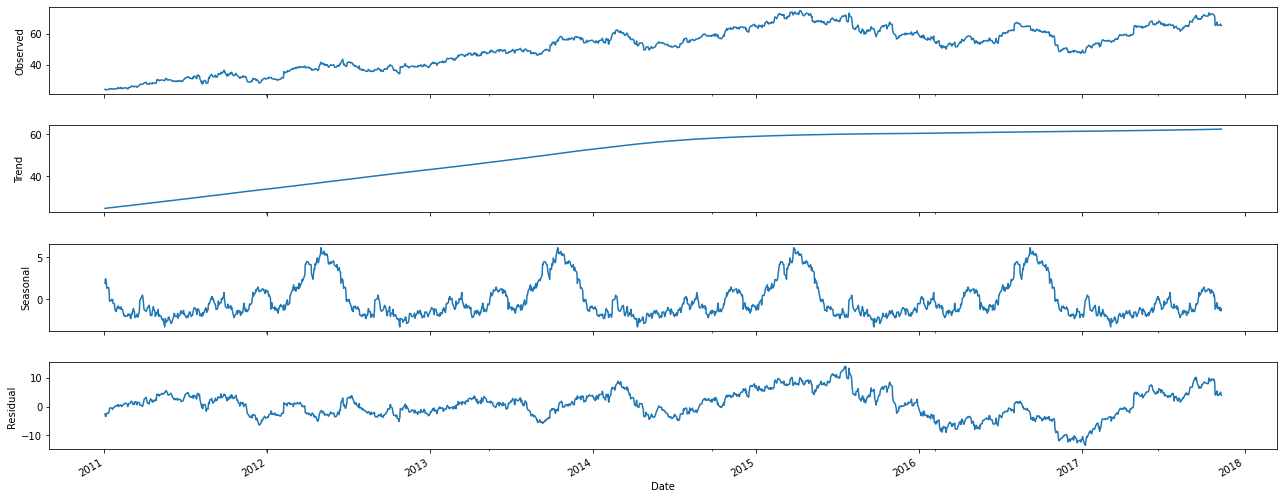

In [321]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

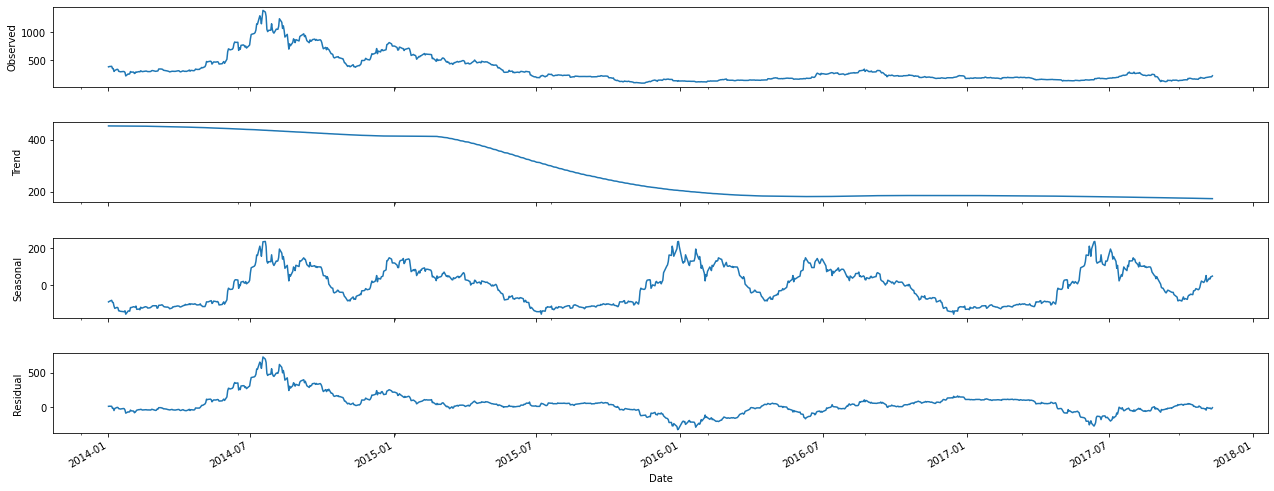

In [322]:
df_close = cr_df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [323]:
configure_plotly_browser_state()


df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [324]:
configure_plotly_browser_state()

cr_df['EMA_9'] = cr_df['Close'].ewm(9).mean().shift()
cr_df['SMA_5'] = cr_df['Close'].rolling(5).mean().shift()
cr_df['SMA_10'] = cr_df['Close'].rolling(10).mean().shift()
cr_df['SMA_15'] = cr_df['Close'].rolling(15).mean().shift()
cr_df['SMA_30'] = cr_df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.Close, name='Close', opacity=0.2))
fig.show()

In [325]:
configure_plotly_browser_state()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [326]:
configure_plotly_browser_state()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

cr_df['RSI'] = relative_strength_idx(cr_df).fillna(0)

fig = go.Figure(go.Scatter(x=cr_df.Date, y=cr_df.RSI, name='RSI'))
fig.show()

In [327]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show(renderer="colab")

In [328]:
EMA_12 = pd.Series(cr_df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(cr_df['Close'].ewm(span=26, min_periods=26).mean())
cr_df['MACD'] = pd.Series(EMA_12 - EMA_26)
cr_df['MACD_signal'] = pd.Series(cr_df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show(renderer="colab")

In [329]:
df['Close'] = df['Close'].shift(-1)

In [330]:
cr_df['Close'] = cr_df['Close'].shift(-1)

In [331]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [332]:
cr_df = cr_df.iloc[33:] # Because of moving averages and MACD line
cr_df = cr_df[:-1]      # Because of shifting close price

cr_df.index = range(len(cr_df))

In [333]:
configure_plotly_browser_state()


test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [334]:
configure_plotly_browser_state()

cr_test_size  = 0.15
cr_valid_size = 0.15

cr_test_split_idx  = int(cr_df.shape[0] * (1-cr_test_size))
cr_valid_split_idx = int(cr_df.shape[0] * (1-(cr_valid_size+cr_test_size)))

cr_train_df  = cr_df.loc[:cr_valid_split_idx].copy()
cr_valid_df  = cr_df.loc[cr_valid_split_idx+1:cr_test_split_idx].copy()
cr_test_df   = cr_df.loc[cr_test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=cr_train_df.Date, y=cr_train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=cr_valid_df.Date, y=cr_valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=cr_test_df.Date,  y=cr_test_df.Close,  name='Test'))
fig.show()

In [335]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [336]:
cr_drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

cr_train_df = cr_train_df.drop(cr_drop_cols, 1)
cr_valid_df = cr_valid_df.drop(cr_drop_cols, 1)
cr_test_df  = cr_test_df.drop(cr_drop_cols, 1)

In [337]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1186 non-null   float64
 1   SMA_5        1186 non-null   float64
 2   SMA_10       1186 non-null   float64
 3   SMA_15       1186 non-null   float64
 4   SMA_30       1186 non-null   float64
 5   RSI          1186 non-null   float64
 6   MACD         1186 non-null   float64
 7   MACD_signal  1186 non-null   float64
dtypes: float64(8)
memory usage: 74.2 KB


In [338]:
cr_y_train = cr_train_df['Close'].copy()
cr_X_train = cr_train_df.drop(['Close'], 1)

cr_y_valid = cr_valid_df['Close'].copy()
cr_X_valid = cr_valid_df.drop(['Close'], 1)

cr_y_test  = cr_test_df['Close'].copy()
cr_X_test  = cr_test_df.drop(['Close'], 1)

cr_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        659 non-null    float64
 1   SMA_5        659 non-null    float64
 2   SMA_10       659 non-null    float64
 3   SMA_15       659 non-null    float64
 4   SMA_30       659 non-null    float64
 5   RSI          659 non-null    float64
 6   MACD         659 non-null    float64
 7   MACD_signal  659 non-null    float64
dtypes: float64(8)
memory usage: 41.3 KB


In [341]:
%%time

parameters = {
    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [12],
    'gamma': [0.01],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.3304538833862109
CPU times: user 3.24 s, sys: 41.8 ms, total: 3.29 s
Wall time: 3.29 s


In [342]:
%%time

cr_parameters = {
    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [12],
    'gamma': [0.01],
    'random_state': [42]
}

cr_eval_set = [(cr_X_train, cr_y_train), (cr_X_valid, cr_y_valid)]
cr_model = xgb.XGBRegressor(eval_set=cr_eval_set, objective='reg:squarederror', verbose=False)
cr_clf = GridSearchCV(cr_model, cr_parameters)

cr_clf.fit(cr_X_train, cr_y_train)

print(f'Best params: {cr_clf.best_params_}')
print(f'Best validation score = {cr_clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.45136059457394284
CPU times: user 2.05 s, sys: 35.9 ms, total: 2.09 s
Wall time: 2.08 s


In [343]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 990 ms, sys: 19 ms, total: 1.01 s
Wall time: 1.01 s


In [344]:
%%time

cr_model = xgb.XGBRegressor(**cr_clf.best_params_, objective='reg:squarederror')
cr_model.fit(cr_X_train, cr_y_train, eval_set=cr_eval_set, verbose=False)

CPU times: user 699 ms, sys: 7.94 ms, total: 707 ms
Wall time: 704 ms


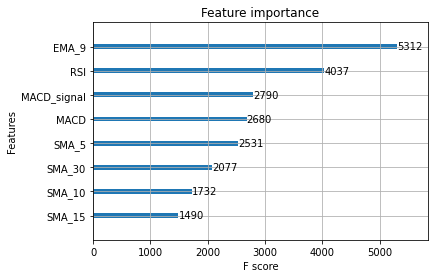

In [345]:
plot_importance(model);

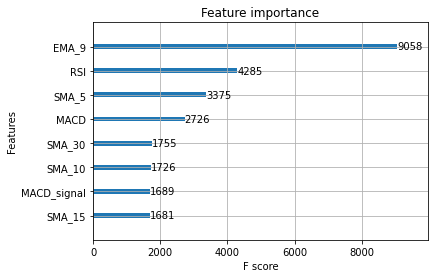

In [346]:
plot_importance(cr_model);

In [347]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [49.435 48.47  48.68  49.2   48.93 ]
y_pred = [51.445953 52.247402 51.97371  50.052147 49.269352]


In [354]:
cr_y_pred = cr_model.predict(cr_test)
print(f'y_true = {np.array(cr_y_test)[:5]}')
print(f'y_pred = {cr_y_pred[:5]}')

y_true = [145.60401055 144.94474193 142.86922724 143.11498979 133.61402998]
y_pred = [122.98071  122.78453  122.694595 122.758095 121.91464 ]


In [349]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2.6122658627707813


In [355]:
print(f'mean_squared_error = {mean_squared_error(cr_y_test, cr_y_pred)}')

mean_squared_error = 308.98208644574095


In [352]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show(renderer="colab")

In [356]:
predicted_prices = cr_df.loc[cr_test_split_idx+1:].copy()
predicted_prices['Close'] = cr_y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=cr_df.Date, y=cr_df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=cr_y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=cr_y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show(renderer="colab")

In [ ]:
# zipfile.ZipFile('./archive.zip').extractall()